In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

In [3]:
class VGG19(nn.Module):
    def __init__(self,dropout=0.5):
        super(VGG19, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3)
        self.conv62 = nn.Conv2d(256, 256, kernel_size=3,padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.mp = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1536,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4)        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv1(x)))
        x = self.dropout(torch.relu(self.conv2(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv3(x)))
        x = self.dropout(torch.relu(self.conv4(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv5(x)))
        x = self.dropout(torch.relu(self.conv6(x)))
        x = self.dropout(torch.relu(self.conv62(x)))
        x = self.dropout(torch.relu(self.conv62(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv7(x)))
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.dropout(torch.relu(self.conv9(x)))
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return torch.log_softmax(x,1)


In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            d = self.data
            l = self.labels
            self.testX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,self.data[i],axis=0)
                l += self.labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Batch Size: 18
Weight Decay: 0.5810997433816847
Dropout: 0.31165035374669575

Fold 1
Epoch Train Loss: 1.294412  Epoch Train Accuracy: 49.027778  Epoch Test Loss: 1.289876  Epoch Test Accuracy: 50.811966
Epoch Train Loss: 1.224998  Epoch Train Accuracy: 49.010417  Epoch Test Loss: 1.221978  Epoch Test Accuracy: 50.811966
Epoch Train Loss: 1.179904  Epoch Train Accuracy: 48.993056  Epoch Test Loss: 1.178114  Epoch Test Accuracy: 49.957265
Epoch Train Loss: 1.153467  Epoch Train Accuracy: 50.989583  Epoch Test Loss: 1.152518  Epoch Test Accuracy: 50.470085
Epoch Train Loss: 1.139685  Epoch Train Accuracy: 50.954861  Epoch Test Loss: 1.139388  Epoch Test Accuracy: 49.401709
Epoch Train Loss: 1.133290  Epoch Train Accuracy: 50.989583  Epoch Test Loss: 1.133326  Epoch Test Accuracy: 49.401709
Epoch Train Loss: 1.130522  Epoch Train Accuracy: 51.041667  Epoch Test Loss: 1.130719  Epoch Test Accuracy: 49.401709
Epoch Train Loss: 1.129322  Epoch Train Accuracy: 50.954861  Epoch Test Loss: 1.12

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fold 2
Epoch Train Loss: 1.310406  Epoch Train Accuracy: 49.492151  Epoch Test Loss: 1.307683  Epoch Test Accuracy: 49.248120
Epoch Train Loss: 1.278373  Epoch Train Accuracy: 49.572946  Epoch Test Loss: 1.277643  Epoch Test Accuracy: 48.345865
Epoch Train Loss: 1.270960  Epoch Train Accuracy: 50.265466  Epoch Test Loss: 1.270722  Epoch Test Accuracy: 52.556391
Epoch Train Loss: 1.269678  Epoch Train Accuracy: 50.184672  Epoch Test Loss: 1.269475  Epoch Test Accuracy: 53.458647
Epoch Train Loss: 1.269431  Epoch Train Accuracy: 50.346260  Epoch Test Loss: 1.269355  Epoch Test Accuracy: 51.654135
Epoch Train Loss: 1.269391  Epoch Train Accuracy: 50.184672  Epoch Test Loss: 1.269329  Epoch Test Accuracy: 51.654135
Epoch Train Loss: 1.269376  Epoch Train Accuracy: 50.265466  Epoch Test Loss: 1.269320  Epoch Test Accuracy: 51.654135
Epoch Train Loss: 1.269374  Epoch Train Accuracy: 50.346260  Epoch Test Loss: 1.269279  Epoch Test Accuracy: 52.556391
Epoch Train Loss: 1.269391  Epoch Train A

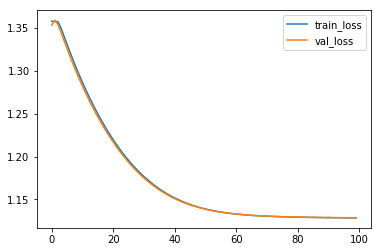

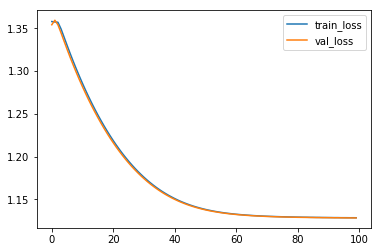

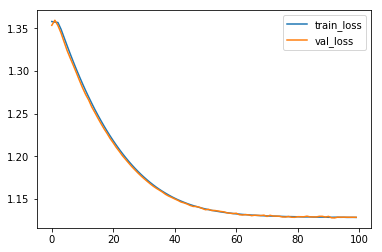

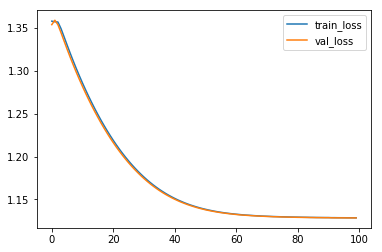

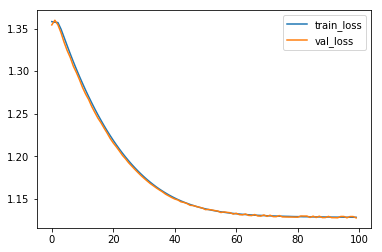

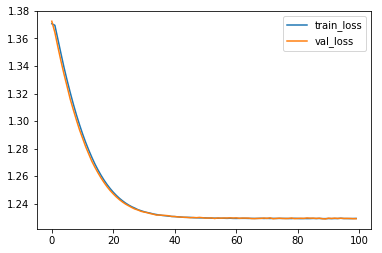

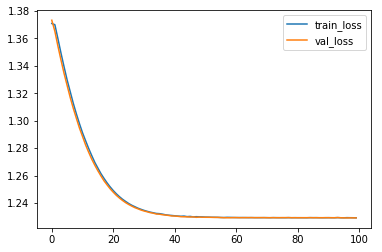

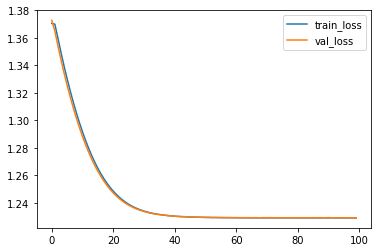

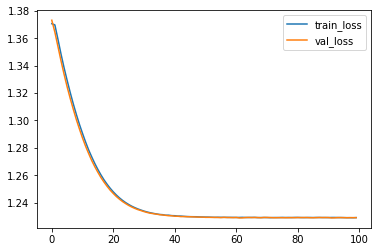

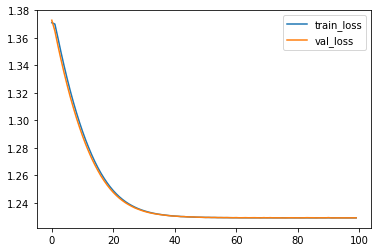

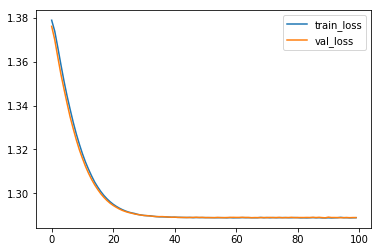

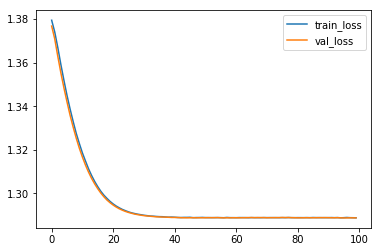

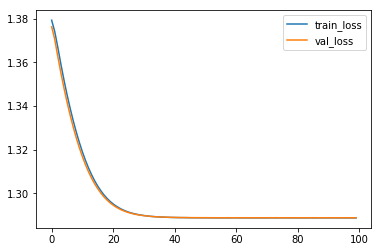

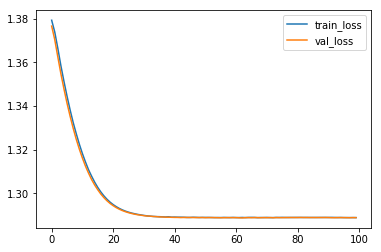

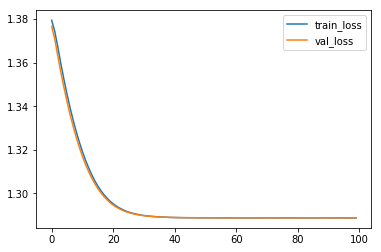

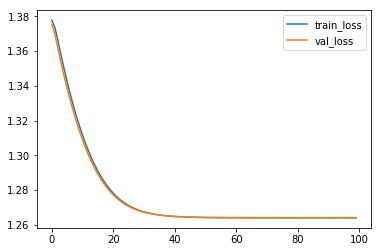

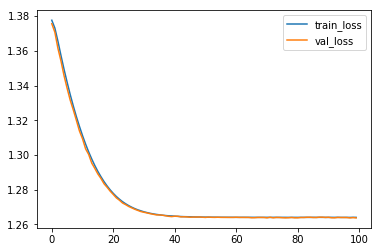

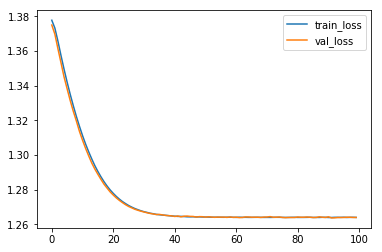

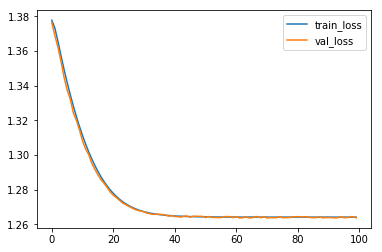

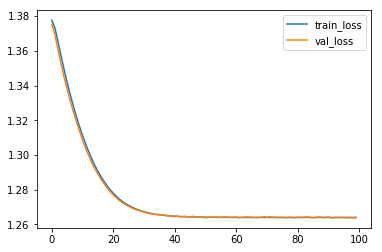

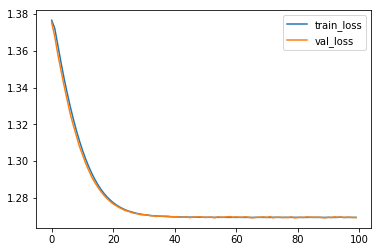

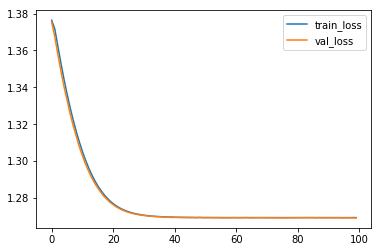

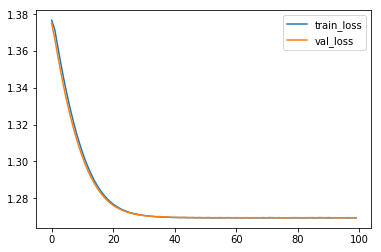

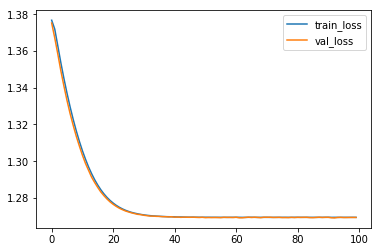

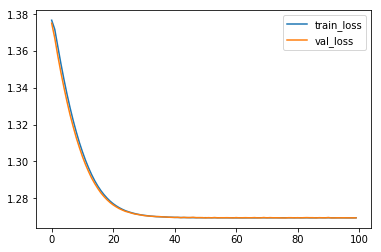

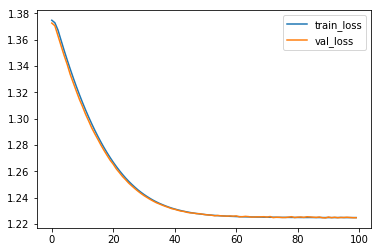

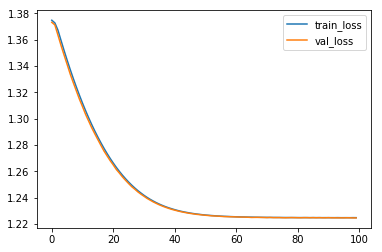

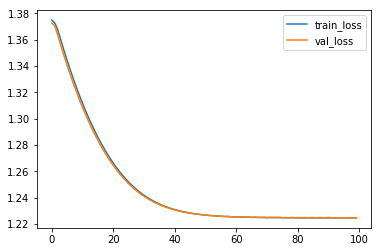

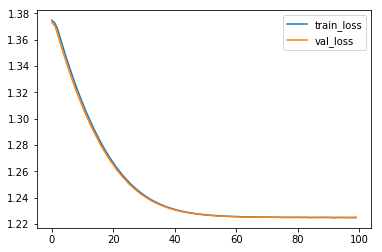

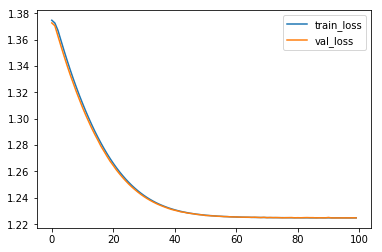

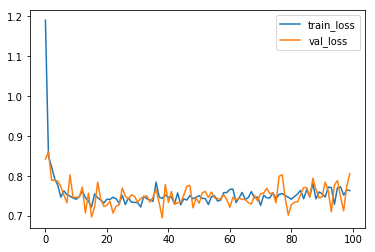

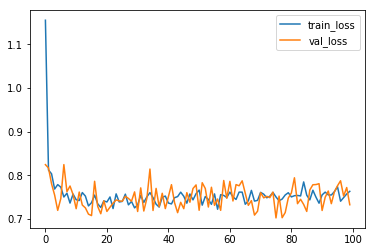

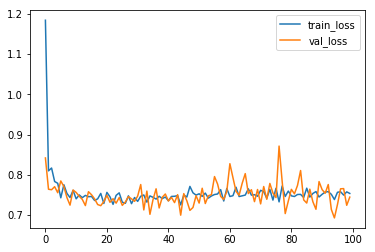

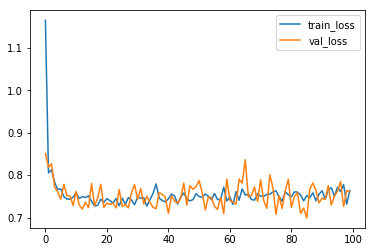

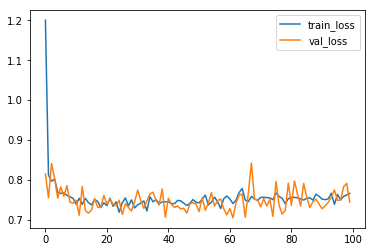

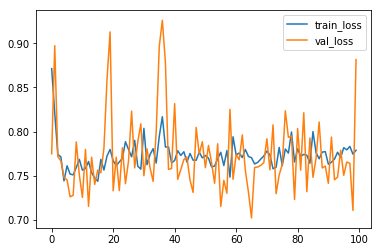

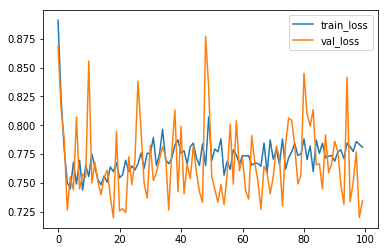

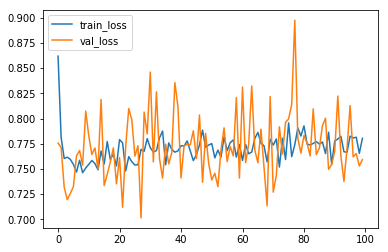

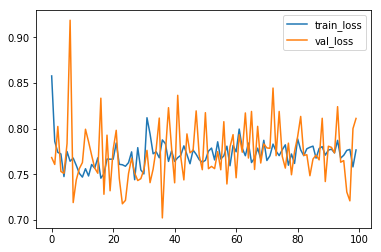

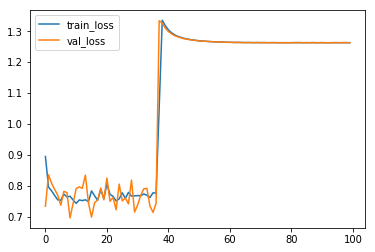

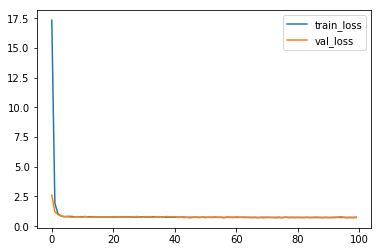

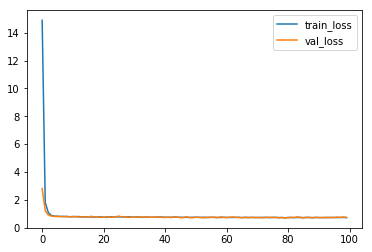

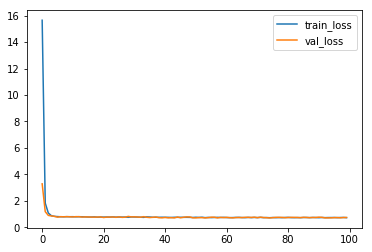

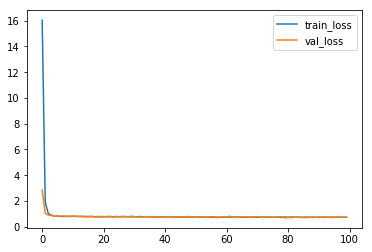

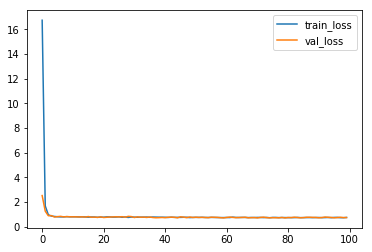

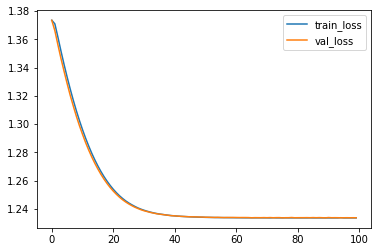

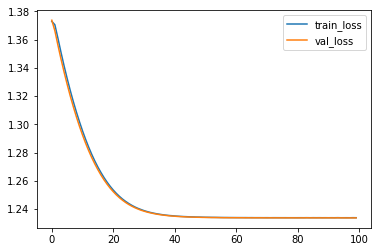

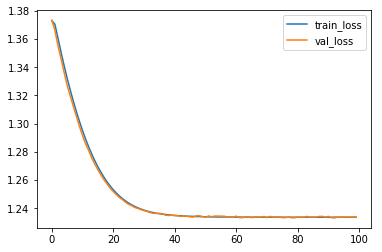

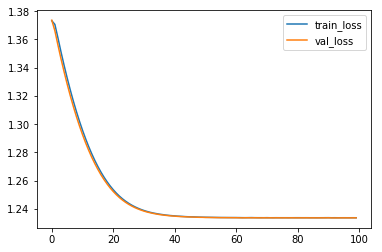

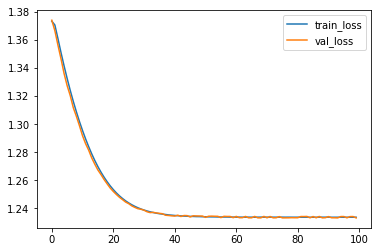

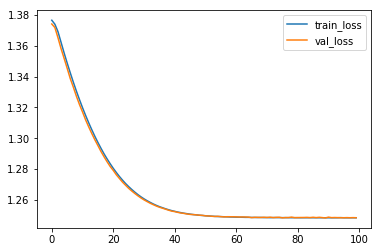

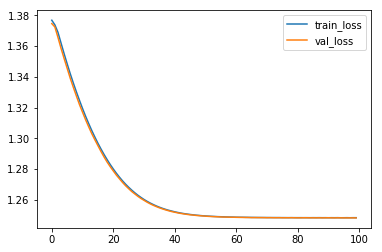

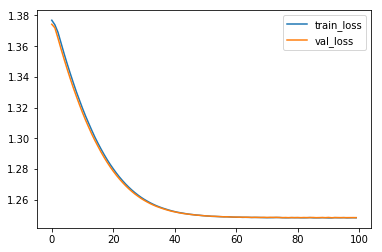

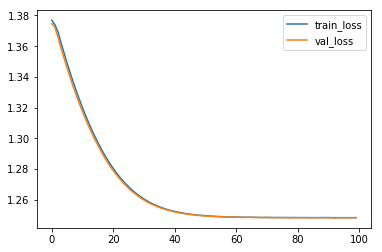

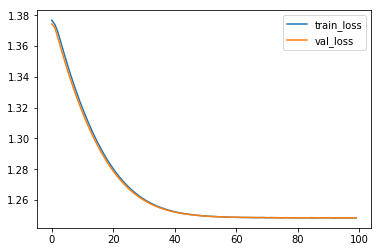

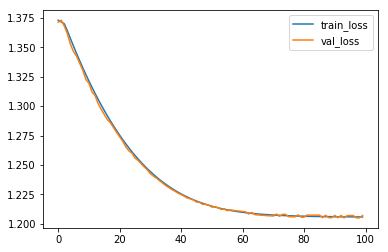

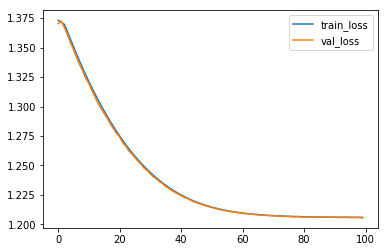

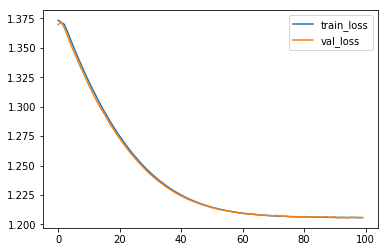

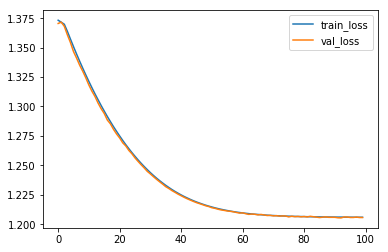

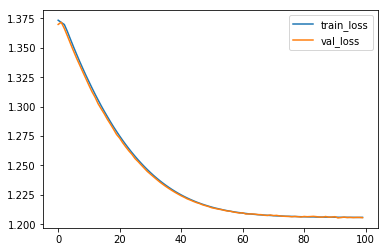

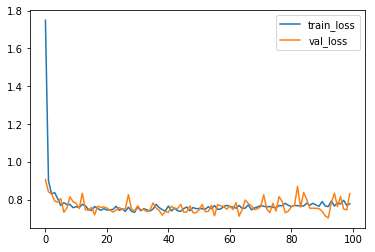

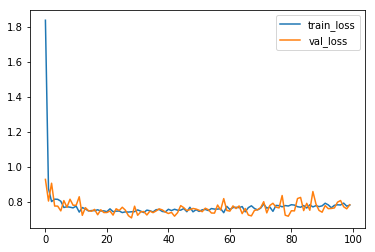

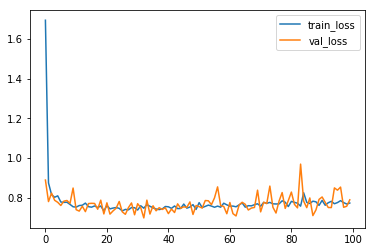

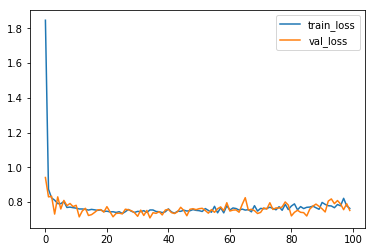

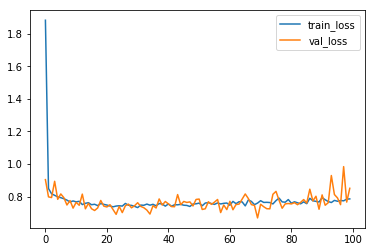

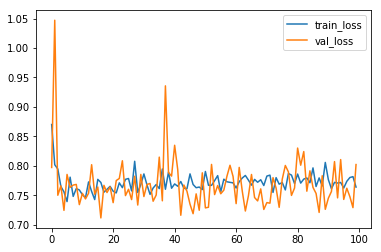

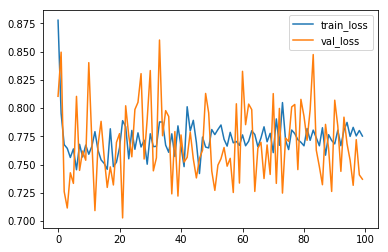

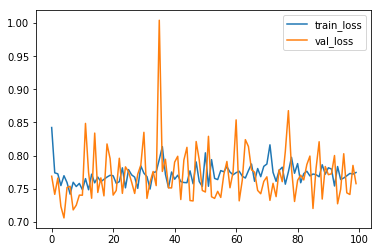

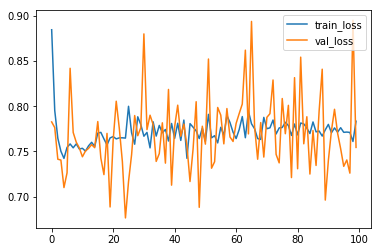

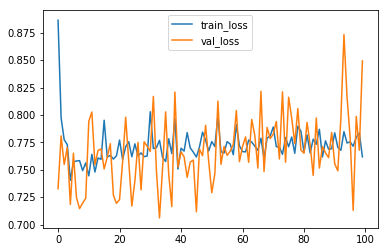

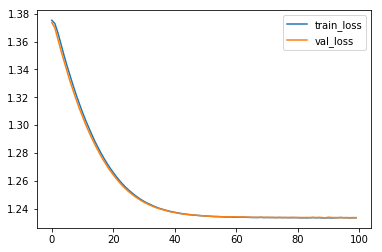

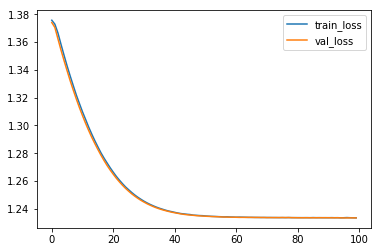

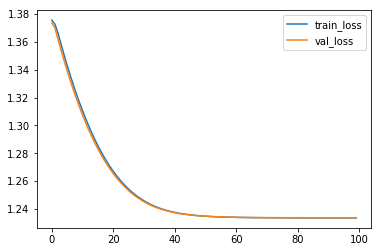

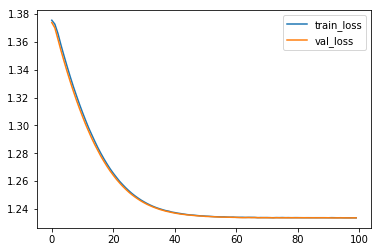

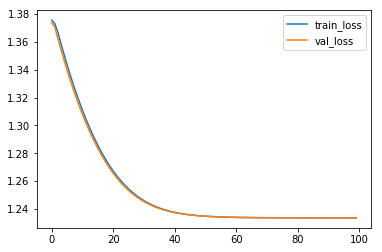

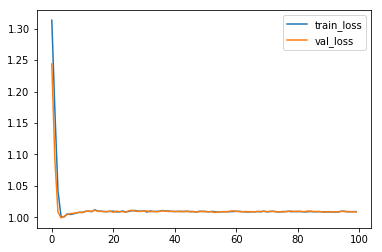

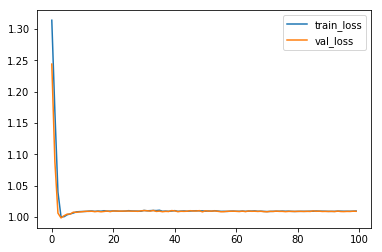

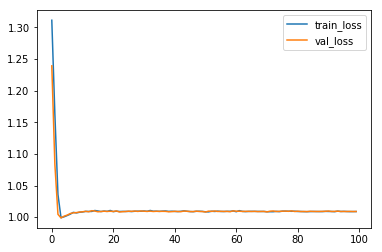

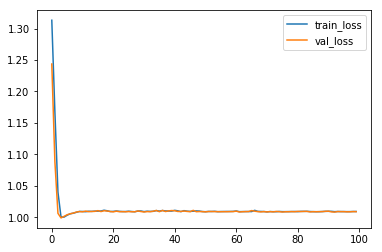

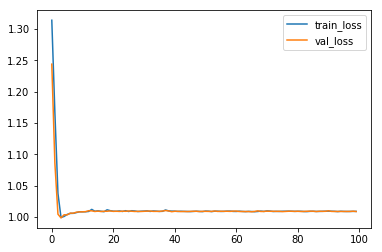

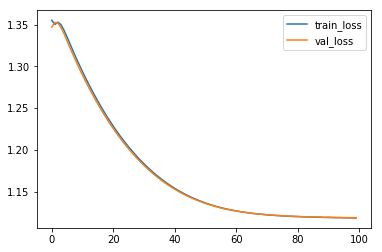

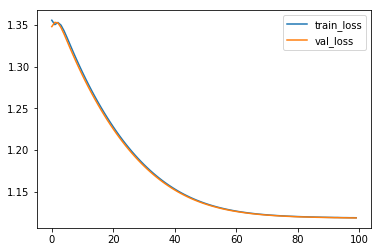

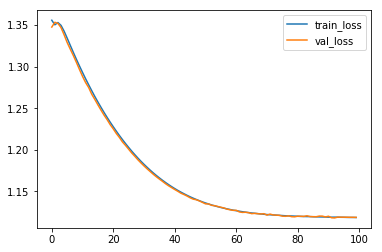

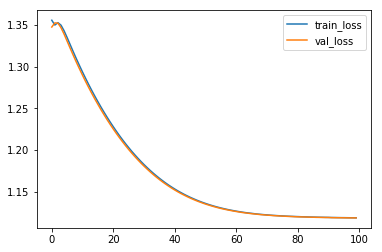

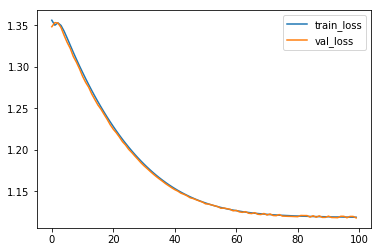

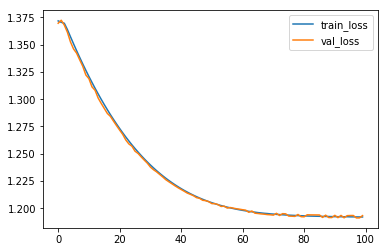

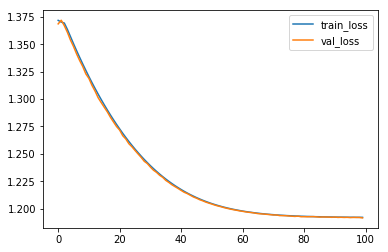

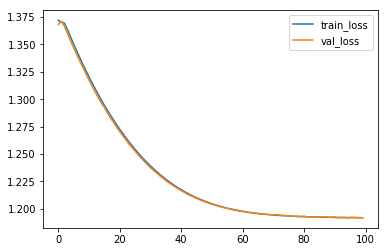

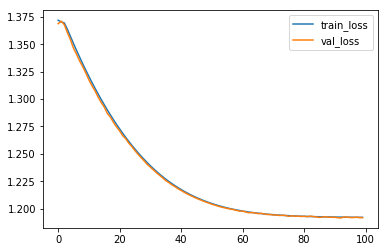

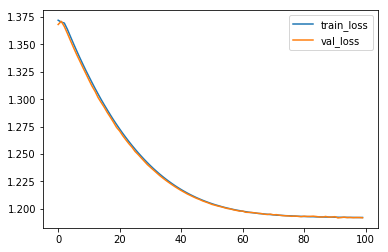

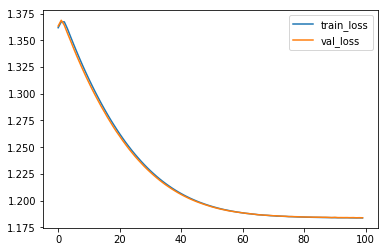

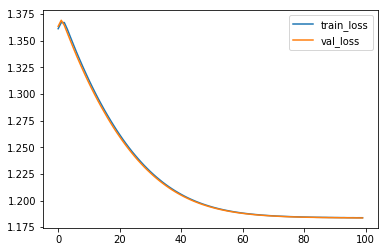

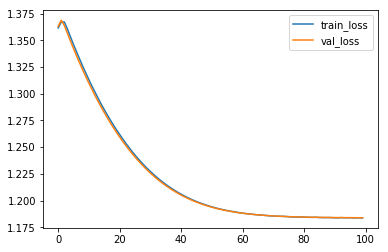

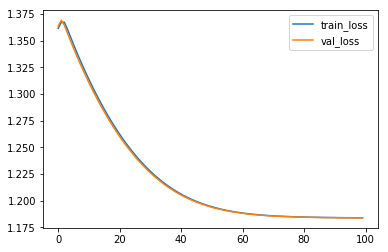

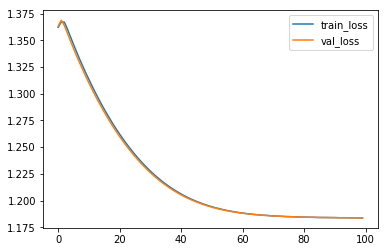

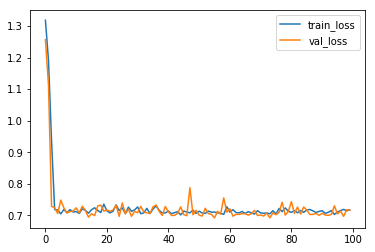

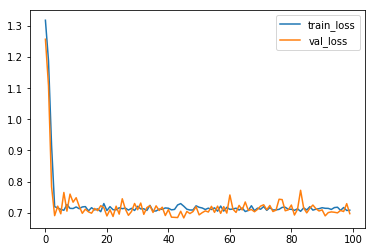

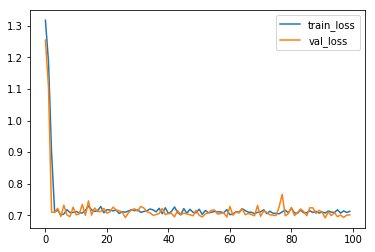

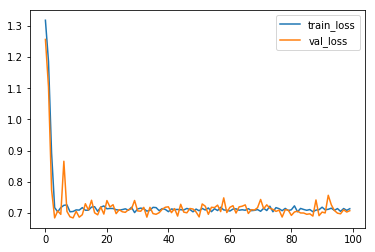

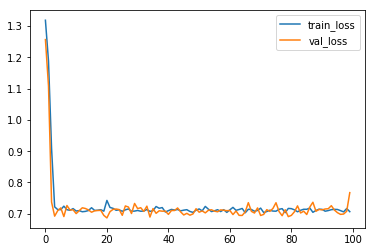

In [6]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

num_attempts = 20

random.seed(4815162352)
batch_sizes = [int(np.round(2 ** random.uniform(4,5))) for i in range(num_attempts)]
dropouts = [random.uniform(0,0.9) for i in range(num_attempts)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(num_attempts)]
stats = []
fbs,fwd,fd = 0,0,0
best_acc = -999

disable = True
epochs = 100
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    dropout = dropouts[i]
    print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
    for i in range(5):
        torch.manual_seed(4815162342)
        model = VGG19(dropout=dropout).cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == every_other - 1:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    if avevacc > best_acc:
        fbs,fwd,fd,best_acc = batch_size, weight_decay, dropout, avevacc
    print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

In [8]:
for i in range(len(stats)):
    print("{:.2f} & {:.2f} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i],dropouts[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in range(len(stats[i]))])))
# hyperparameters
batch_size = fbs
weight_decay = fwd
dropout = fd
disable = False
epochs = 100
every_other = 10

# initializing training objects
torch.manual_seed(4815162342)
model = VGG19(dropout=dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# initializing dataset
my_data = AutoUXDataset(data,labels,True)
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
my_loader = DataLoader(my_data, batch_size=batch_size,shuffle=True)
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
my_data.setTest(-1)
my_val.setTest(-1)

# initializing tracking variables
dlosscurve = []
dacccurve = []
vlosscurve = []
vacccurve = []

# training loop
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    vloss, vacc = test(model,criterion,my_val_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    vlosscurve.append(vloss)
    vacccurve.append(vacc)
    if j % every_other == every_other - 1:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))

print("Batch Size: {}\nWeight Decay: {}\nDropout: {}\n".format(batch_size,weight_decay,dropout))
print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{} & {:.2f} & N/A & {:.2f} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,dropout,dloss,dacc * 100,vloss, vacc * 100))

18.00 & 0.58 & 0.31 & 1.13 & 50.70\% & 1.13 & 51.63\% \\ \hline
17.00 & 1.21 & 0.71 & 1.23 & 50.85\% & 1.23 & 51.32\% \\ \hline
23.00 & 2.19 & 0.21 & 1.29 & 51.05\% & 1.29 & 50.78\% \\ \hline
22.00 & 1.66 & 0.25 & 1.26 & 50.68\% & 1.26 & 53.51\% \\ \hline
19.00 & 1.76 & 0.68 & 1.27 & 50.69\% & 1.27 & 51.66\% \\ \hline
24.00 & 1.16 & 0.21 & 1.22 & 50.72\% & 1.22 & 51.47\% \\ \hline
27.00 & 0.77 & 0.83 & 0.76 & 48.44\% & 0.76 & 50.84\% \\ \hline
18.00 & 1.64 & 0.78 & 0.88 & 50.49\% & 0.89 & 51.59\% \\ \hline
19.00 & 0.56 & 0.88 & 0.73 & 50.45\% & 0.74 & 49.16\% \\ \hline
18.00 & 1.26 & 0.68 & 1.23 & 50.70\% & 1.23 & 51.63\% \\ \hline
27.00 & 1.43 & 0.51 & 1.25 & 50.65\% & 1.25 & 50.86\% \\ \hline
29.00 & 1.00 & 0.40 & 1.21 & 50.71\% & 1.21 & 51.64\% \\ \hline
20.00 & 1.25 & 0.84 & 0.78 & 49.06\% & 0.80 & 49.76\% \\ \hline
16.00 & 1.20 & 0.79 & 0.77 & 49.90\% & 0.78 & 50.76\% \\ \hline
23.00 & 1.25 & 0.11 & 1.23 & 51.05\% & 1.23 & 50.78\% \\ \hline
24.00 & 0.27 & 0.09 & 1.01 & 50.69\% & 1

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.85it/s]


Epoch Train Loss: 1.304971  Epoch Train Accuracy: 49.317755  Epoch Test Loss: 1.300106  Epoch Test Accuracy: 69.696970


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.39it/s]


Epoch Train Loss: 1.272380  Epoch Train Accuracy: 48.618455  Epoch Test Loss: 1.271713  Epoch Test Accuracy: 30.303030


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.59it/s]


Epoch Train Loss: 1.265380  Epoch Train Accuracy: 50.835750  Epoch Test Loss: 1.266233  Epoch Test Accuracy: 30.303030


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.39it/s]


Epoch Train Loss: 1.264269  Epoch Train Accuracy: 50.682245  Epoch Test Loss: 1.265771  Epoch Test Accuracy: 30.303030


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.53it/s]


Epoch Train Loss: 1.264094  Epoch Train Accuracy: 50.758997  Epoch Test Loss: 1.263416  Epoch Test Accuracy: 62.121212


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.34it/s]


Epoch Train Loss: 1.264063  Epoch Train Accuracy: 50.528740  Epoch Test Loss: 1.263150  Epoch Test Accuracy: 62.121212


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.98it/s]


Epoch Train Loss: 1.264061  Epoch Train Accuracy: 50.605492  Epoch Test Loss: 1.265538  Epoch Test Accuracy: 30.303030


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.97it/s]


Epoch Train Loss: 1.264116  Epoch Train Accuracy: 50.912502  Epoch Test Loss: 1.264880  Epoch Test Accuracy: 30.303030


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.16it/s]


Epoch Train Loss: 1.264041  Epoch Train Accuracy: 50.835750  Epoch Test Loss: 1.265643  Epoch Test Accuracy: 30.303030


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.21it/s]


Epoch Train Loss: 1.264041  Epoch Train Accuracy: 50.758997  Epoch Test Loss: 1.265866  Epoch Test Accuracy: 30.303030
Batch Size: 22
Weight Decay: 1.6638212990229493
Dropout: 0.2465584018812539

Train Loss: 1.264041
Train Accuracy: 50.758997
Validation Loss: 1.265866
Validation Accuracy: 30.303030

22 & 1.66 & N/A & 0.25 & 1.26 & 50.76\% & 1.27 & 30.30\% \\ \hline


In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
with open('VGG19outprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('VGG19out.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))